In [1]:
import os
import json
import shutil
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
root = 'data'

In [3]:
train_path = os.path.join(root, 'train.json')
test_path = os.path.join(root, 'test.json')

In [4]:
with open(train_path, 'r') as fp:
    train = dict(json.load(fp))
# with open(test_path, 'r') as fp:
#     test = dict(json.load(fp))

In [5]:
print('Train keys:', train.keys())
# print('Test keys:', test.keys())

Train keys: dict_keys(['info', 'lincenses', 'images', 'type', 'annotations', 'categories'])


In [6]:
# Info contains no information, nor licenses, nor type
print(train['info'])
# print(test['info'])
print(train['lincenses'])
# print(test['licenses'])

None
None


In [7]:
for i in train['categories']:
    print(i)

{'id': 1, 'name': '瓜子壳'}
{'id': 2, 'name': '核桃'}
{'id': 3, 'name': '花生壳'}
{'id': 4, 'name': '毛豆壳'}
{'id': 5, 'name': '西瓜子'}
{'id': 6, 'name': '枣核'}
{'id': 7, 'name': '话梅核'}
{'id': 8, 'name': '苹果皮'}
{'id': 9, 'name': '柿子皮'}
{'id': 10, 'name': '西瓜皮'}
{'id': 11, 'name': '香蕉皮'}
{'id': 12, 'name': '柚子皮'}
{'id': 13, 'name': '荔枝壳'}
{'id': 14, 'name': '芒果皮'}
{'id': 15, 'name': '苹果核'}
{'id': 16, 'name': '干果'}
{'id': 17, 'name': '桔子皮'}
{'id': 18, 'name': '饼干'}
{'id': 19, 'name': '面包'}
{'id': 20, 'name': '糖果'}
{'id': 21, 'name': '宠物饲料'}
{'id': 22, 'name': '风干食品'}
{'id': 23, 'name': '蜜饯'}
{'id': 24, 'name': '肉干'}
{'id': 25, 'name': '冲泡饮料粉'}
{'id': 26, 'name': '奶酪'}
{'id': 27, 'name': '罐头'}
{'id': 28, 'name': '糕饼'}
{'id': 29, 'name': '薯片'}
{'id': 30, 'name': '树叶'}
{'id': 31, 'name': '杂草'}
{'id': 32, 'name': '绿植'}
{'id': 33, 'name': '鲜花'}
{'id': 34, 'name': '豆类'}
{'id': 35, 'name': '动物内脏'}
{'id': 36, 'name': '绿豆饭'}
{'id': 37, 'name': '谷类及加工物'}
{'id': 38, 'name': '贝类去硬壳'}
{'id': 39, 'name': '虾'}
{'id

{'file_name': 'images_withoutrect/11003.png', 'height': 1080, 'width': 1920, 'image_id': 11003}
Height (1079, 2448, 1080.0249125, 6.840633513596804)


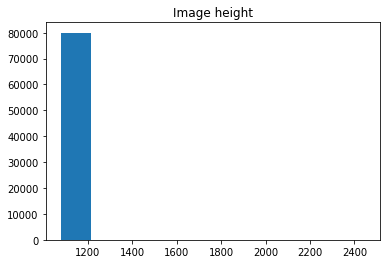

Width (1079, 2448, 1080.0249125, 6.840633513596804)


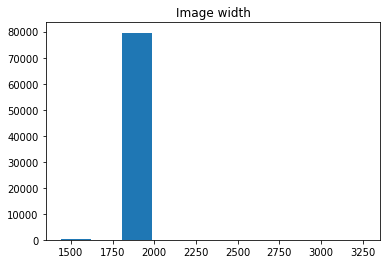

num_pixels (1079, 2448, 1080.0249125, 6.840633513596804)


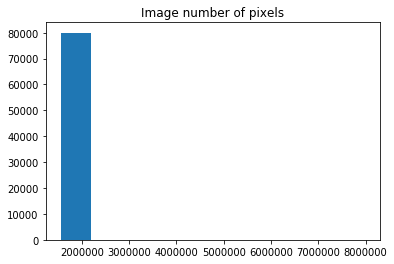

Width/height (1.0, 1.7794253938832252, 1.775516691123469, 0.031778638031739415)


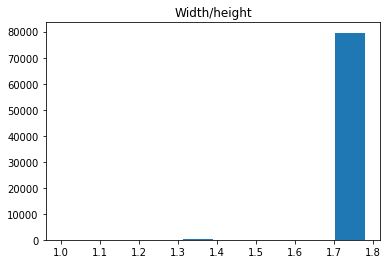

In [8]:
# Contains name and img_id
print(train['images'][0])
extract = lambda json, key: np.array([element[key] for element in json])
# 5-number summary
analyze = lambda x: (x.min(), x.max(), x.mean(), x.std())

image_id, height, width = extract(train['images'], 'image_id'), extract(train['images'], 'height'),\
                            extract(train['images'], 'width')
print('Height', analyze(height))
plt.title('Image height')
plt.hist(height)
plt.show()

print('Width', analyze(height))
plt.title('Image width')
plt.hist(width)
plt.show()

print('num_pixels', analyze(height))
plt.title('Image number of pixels')
plt.hist(width*height)
plt.show()

print('Width/height', analyze(width/height))
plt.title('Width/height')
plt.hist(width / height)
plt.show()

In [9]:
print(train['annotations'][0])
# Annotations & width_height are one-to-one correspondence
print(extract(train['annotations'], 'image_id') == image_id)

bboxs = extract(train['annotations'], 'bbox')
bb1, bb2, bb3, bb4 = bboxs[:, 0], bboxs[:, 1], bboxs[:, 2], bboxs[:, 3]
# MINUS 1!
labels = extract(train['annotations'], 'category_id') - 1

{'area': 81909.20209190401, 'iscrowd': 0, 'image_id': 11003, 'bbox': [636.08832, 305.77176, 298.5888, 274.32108000000005], 'category_id': 2}
[ True  True  True ...  True  True  True]


(198, 791, 404.04040404040404, 47.76582591235366)


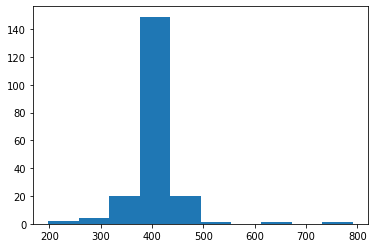

In [10]:
label_frequency = np.array([(labels == i).sum() for i in np.unique(labels)])
print(analyze(label_frequency))
plt.hist(label_frequency)
plt.show()

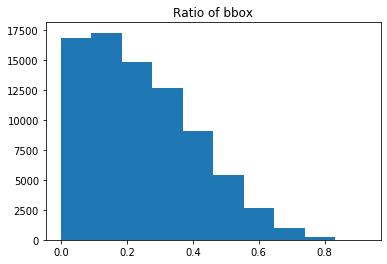

In [11]:
# cropped_img = img[bb2:bb2+bb4, bb1:bb1+bb3, :]

ratio = bb4*bb3 / (height*width)
plt.title('Ratio of bbox')
plt.hist(ratio)
plt.show()

1080 1920 1080 1920


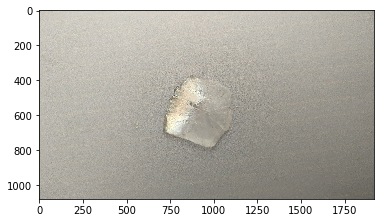

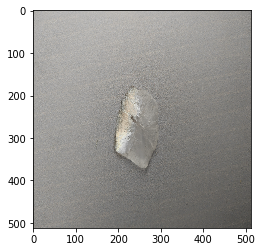

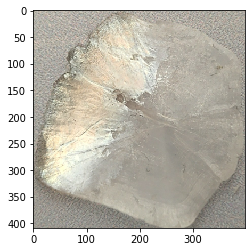

In [23]:
import cv2 
from albumentations import *
transforms = Compose([
    Flip(p=.75),
    Resize(512, 512),
    OneOf([
        RandomBrightnessContrast(),
        RandomGamma(),
        HueSaturationValue(hue_shift_limit=0, sat_shift_limit=20, val_shift_limit=50),
    ]),
    OneOf([
        GaussianBlur(),
        Blur(),
        MedianBlur(),
    ]),
    OneOf([
        RandomResizedCrop(512, 512, scale=(.5, 1.), p=.25),
        ShiftScaleRotate(scale_limit=.2, p=.75),
    ]),
])

def show(i, root='data/train'):
    img = (plt.imread(os.path.join(root, str(image_id[i])+'.png')) * 255).astype(np.uint8)
    cropped = img[int(bb2[i]):int(bb2[i]+bb4[i]), int(bb1[i]):int(bb1[i]+bb3[i]), :]
    print(img.shape[0], img.shape[1], height[i], width[i])
    plt.imshow(img)
    plt.show()
    plt.imshow(transforms(image=img)['image'])
    plt.show()
    plt.imshow(cropped)
    plt.show()
show(10100)

In [13]:
# Height:: dim 0, bb2:bb2+bb4; width::dim 1, bb1:bb1+bb3
bb2_, bb4_ = bb2 / height, bb4 / height
bb1_, bb3_ = bb1 / width, bb3 / width

df = {'image_id':image_id, 'label':labels, 'bb1':bb1_, 'bb2':bb2_, 'bb3':bb3_, 'bb4':bb4_, 'H':height, 'W':width}
df = pd.DataFrame(df)
df.to_csv(os.path.join(root, 'train.csv'), index=False)
df.head()

,image_id,label,bb1,bb2,bb3,bb4,H,W
0,11003,1,0.331296,0.283122,0.155515,0.254001,1080,1920
1,11004,1,0.418985,0.389408,0.159619,0.318060,1080,1920
2,11005,1,0.414004,0.355382,0.173154,0.302320,1080,1920
3,11006,1,0.373260,0.293015,0.227273,0.381127,1080,1920
4,11007,1,0.327842,0.399695,0.193859,0.256335,1080,1920


In [14]:
# Preprocessing data: Resize to 384x384
pre_path = 'data/train'
dest_path = 'data/train_512'
img_size = 512

if os.path.exists(dest_path):
    shutil.rmtree(dest_path)

os.mkdir(dest_path)

In [15]:
import cv2 
from PIL import Image
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader

class dummy_dataset(Dataset):
    def __init__(self):
        self.names = list(os.listdir(pre_path))
        self.len = len(self.names)
    
    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
        try:
            name = os.path.join(pre_path, self.names[idx])
            img = np.array(Image.open(name))
            img = cv2.resize(img, (img_size, img_size), cv2.INTER_LANCZOS4)
            cv2.imwrite(os.path.join(dest_path, self.names[idx]), img)
            return 0
        except:
            print(name)
            return 0

In [ ]:
ds = dummy_dataset()
dummy_dl = DataLoader(ds, num_workers=24, batch_size=96*2)
for _ in tqdm(dummy_dl):
    pass